In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns

match_info = pd.read_csv("data/matches_info.csv")
possessions = pd.read_csv("data/possessions.csv")
run_features = pd.read_csv("data/run_features.csv")
tracking_data = pd.read_csv("data/tracking_data.csv")
player_to_team = pd.read_csv("data/player_team.csv").set_index("id")

merged = pd.merge(possessions,run_features,on=["match_id","possession_index"],how="outer",suffixes=("_possession","_run"))

merged["possession_lead_to_shot"] = (merged["possession_lead_to_shot"] | merged["lead_to_shot"])# Need to update wheter runs and possessions lead to shots on values that conflict
merged["possession_lead_to_goal"] = (merged["possession_lead_to_goal"] | merged["lead_to_goal"])

runs_behind = merged[merged.event_subtype == "behind"].dropna()
runs_behind["player_id"] = runs_behind["player_id"].astype(int)

In [16]:
tracking_data

,period_id,timestamp,frame_id,ball_x,ball_y,ball_speed,match_id,run_id,run_active,id,...,ball_dy,ball_dx_smooth,ball_dy_smooth,ball_ax,ball_ay,ball_ax_smooth,ball_ay_smooth,ball_speed_direction,ball_acceleration,ball_acc_direction
0,1,0 days 00:00:04.400000,54,-21.42,1.83,NaN,1886347,1_0,False,1_0,...,NaN,-0.015000,0.125000,NaN,NaN,0.052500,0.110000,NaN,NaN,NaN
1,1,0 days 00:00:04.500000,55,-21.46,1.93,1.077033,1886347,1_0,False,1_0,...,0.10,0.030000,0.206667,-0.025,-0.025000,0.053000,0.128333,1.951303,-1.392702,-2.356194
2,1,0 days 00:00:04.600000,56,-21.45,2.08,1.503330,1886347,1_0,False,1_0,...,0.15,0.090000,0.345000,-0.020,-0.056667,0.060250,0.162250,1.504228,-5.787115,-1.910089
3,1,0 days 00:00:04.700000,57,-21.33,2.45,3.889730,1886347,1_0,False,1_0,...,0.37,0.144000,0.510000,0.030,0.025000,0.060600,0.185000,1.257176,3.303563,0.694738
4,1,0 days 00:00:04.800000,58,-21.06,3.21,8.065358,1886347,1_0,False,1_0,...,0.76,0.226000,0.774000,0.126,0.250000,0.058400,0.213467,1.229440,27.775546,1.103954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6705575,1,0 days 00:16:11,12220,2.78,-10.07,4.825971,2017461,1_99,False,1_99,...,-0.48,0.076000,-0.472000,-0.036,0.022000,-0.012800,0.019600,-1.467004,-2.561137,2.593043
6705576,1,0 days 00:16:11.100000,12221,2.86,-10.51,4.472136,2017461,1_99,False,1_99,...,-0.44,0.066000,-0.430000,0.004,0.032000,-0.009000,0.028000,-1.390943,-3.076823,1.446441
6705577,1,0 days 00:16:11.200000,12222,2.94,-10.90,3.981206,2017461,1_99,False,1_99,...,-0.39,0.054000,-0.392000,0.014,0.040000,-0.007867,0.031067,-1.368475,-3.637080,1.234122
6705578,1,0 days 00:16:11.300000,12223,2.99,-11.23,3.337664,2017461,1_99,False,1_99,...,-0.33,0.055000,-0.370000,-0.004,0.062000,-0.007333,0.031333,-1.420425,-6.189940,1.635223


In [21]:
import numpy as np

tracking_data = tracking_data.sort_values(
    ["match_id","run_id","player", "timestamp"]
)

tracking_data["dx"] = (
    tracking_data["x"]
    - tracking_data.groupby(["match_id","player", "run_id"])["x"].shift(1)
)
tracking_data["dy"] = (
    tracking_data["y"]
    - tracking_data.groupby(["match_id","player", "run_id"])["y"].shift(1)
)

tracking_data["ax"] = (
    tracking_data["dx"]
    - tracking_data.groupby(["match_id","player", "run_id"])["dx_smooth"].shift(1)
)
tracking_data["ay"] = (
    tracking_data["dy"]
    - tracking_data.groupby(["match_id","player", "run_id"])["dy_smooth"].shift(1)
)
# Fill na first rows
tracking_data[["dx", "dy","ax","ay"]] = (
    tracking_data.groupby(["match_id", "run_id", "player"])[["dx", "dy","ax","ay"]]
      .bfill()
)

#Speed
FPS = 10

tracking_data["speed"] = (
    np.sqrt(
        tracking_data["dx"]**2 +
        tracking_data["dy"]**2
    ) * FPS
)
tracking_data["speed_direction"] = np.arctan2(
    tracking_data["dy"],
    tracking_data["dx"]
)
eps = 1e-6

vx = tracking_data["dx"]
vy = tracking_data["dy"]
speed_frame = np.sqrt(vx**2 + vy**2)

vhat_x = vx / (speed_frame + eps)
vhat_y = vy / (speed_frame + eps)

tracking_data["acceleration"] = (
    (tracking_data["ax"] * vhat_x +
     tracking_data["ay"] * vhat_y)
    * FPS**2
)
tracking_data["acc_direction"] = np.arctan2(
    tracking_data["ay"],
    tracking_data["ax"]
)

In [20]:
import numpy as np
FPS = 10
eps = 1e-6
# Ball Speed and acceleration
tracking_data["ball_dx"] = (
    tracking_data["ball_x"]
    - tracking_data.groupby(["match_id", "period_id","run_id"])["ball_x"].shift(1)
)

tracking_data["ball_dy"] = (
    tracking_data["ball_y"]
    - tracking_data.groupby(["match_id", "period_id","run_id"])["ball_y"].shift(1)
)

tracking_data["ball_ax"] = (
    tracking_data["ball_dx"]
    - tracking_data.groupby(["match_id", "period_id","run_id"])["ball_dx_smooth"].shift(1)
)

tracking_data["ball_ay"] = (
    tracking_data["ball_dy"]
    - tracking_data.groupby(["match_id", "period_id","run_id"])["ball_dy_smooth"].shift(1)
)
# Fill na first rows
tracking_data[["ball_dx", "ball_dy","ball_ax","ball_ay"]] = (
    tracking_data.groupby(["match_id", "run_id", "player"])[["ball_dx", "ball_dy","ball_ax","ball_ay"]]
      .bfill()
)

tracking_data["ball_speed"] = (
    np.sqrt(
        tracking_data["ball_dx"]**2 +
        tracking_data["ball_dy"]**2
    ) * FPS
)

tracking_data["ball_speed_direction"] = np.arctan2(
    tracking_data["ball_dy"],
    tracking_data["ball_dx"]
)
vx = tracking_data["ball_dx"]
vy = tracking_data["ball_dy"]

speed_frame = np.sqrt(vx**2 + vy**2)

vhat_x = vx / (speed_frame + eps)
vhat_y = vy / (speed_frame + eps)

tracking_data["ball_acceleration"] = (
    (tracking_data["ball_ax"] * vhat_x +
     tracking_data["ball_ay"] * vhat_y)
    * FPS**2
)

tracking_data["ball_acc_direction"] = np.arctan2(
    tracking_data["ball_ay"],
    tracking_data["ball_ax"]
)


In [23]:
tracking_data.to_csv("data/tracking_data.csv",index=False)

In [22]:
tracking_data

,period_id,timestamp,frame_id,ball_x,ball_y,ball_speed,match_id,run_id,run_active,id,...,ball_dy,ball_dx_smooth,ball_dy_smooth,ball_ax,ball_ay,ball_ax_smooth,ball_ay_smooth,ball_speed_direction,ball_acceleration,ball_acc_direction
0,1,0 days 00:00:04.400000,54,-21.42,1.83,1.077033,1886347,1_0,False,1_0,...,0.10,-0.015000,0.125000,-0.025,-0.025000,0.052500,0.110000,1.951303,-1.392702,-2.356194
1,1,0 days 00:00:04.500000,55,-21.46,1.93,1.077033,1886347,1_0,False,1_0,...,0.10,0.030000,0.206667,-0.025,-0.025000,0.053000,0.128333,1.951303,-1.392702,-2.356194
2,1,0 days 00:00:04.600000,56,-21.45,2.08,1.503330,1886347,1_0,False,1_0,...,0.15,0.090000,0.345000,-0.020,-0.056667,0.060250,0.162250,1.504228,-5.787115,-1.910089
3,1,0 days 00:00:04.700000,57,-21.33,2.45,3.889730,1886347,1_0,False,1_0,...,0.37,0.144000,0.510000,0.030,0.025000,0.060600,0.185000,1.257176,3.303563,0.694738
4,1,0 days 00:00:04.800000,58,-21.06,3.21,8.065358,1886347,1_0,False,1_0,...,0.76,0.226000,0.774000,0.126,0.250000,0.058400,0.213467,1.229440,27.775546,1.103954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6705575,1,0 days 00:16:11,12220,2.78,-10.07,4.825971,2017461,1_99,False,1_99,...,-0.48,0.076000,-0.472000,-0.036,0.022000,-0.012800,0.019600,-1.467004,-2.561137,2.593043
6705576,1,0 days 00:16:11.100000,12221,2.86,-10.51,4.472136,2017461,1_99,False,1_99,...,-0.44,0.066000,-0.430000,0.004,0.032000,-0.009000,0.028000,-1.390943,-3.076823,1.446441
6705577,1,0 days 00:16:11.200000,12222,2.94,-10.90,3.981206,2017461,1_99,False,1_99,...,-0.39,0.054000,-0.392000,0.014,0.040000,-0.007867,0.031067,-1.368475,-3.637080,1.234122
6705578,1,0 days 00:16:11.300000,12223,2.99,-11.23,3.337664,2017461,1_99,False,1_99,...,-0.33,0.055000,-0.370000,-0.004,0.062000,-0.007333,0.031333,-1.420425,-6.189940,1.635223


In [ ]:
RUN_NUM = 4
run = run_features.iloc[RUN_NUM]
match_id = run["match_id"]
run_id = run["id"]
player = run["player_id"]
player

np.int64(11885)

In [129]:
run_tracking = tracking_data[(tracking_data.player==player) & (tracking_data.run_id == run_id) & (tracking_data.match_id == match_id)]
run_tracking["timestamp"] = pd.to_timedelta(run_tracking["timestamp"]).dt.total_seconds()

C:\Users\zcoch\AppData\Local\Temp\ipykernel_16400\1198987197.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_tracking["timestamp"] = pd.to_timedelta(run_tracking["timestamp"]).dt.total_seconds()


In [130]:
from visualization_tools import animate_run, plot_run

# %matplotlib tk
# animate_run(run=run,tracking_data=tracking_data,player_to_team=player_to_team)

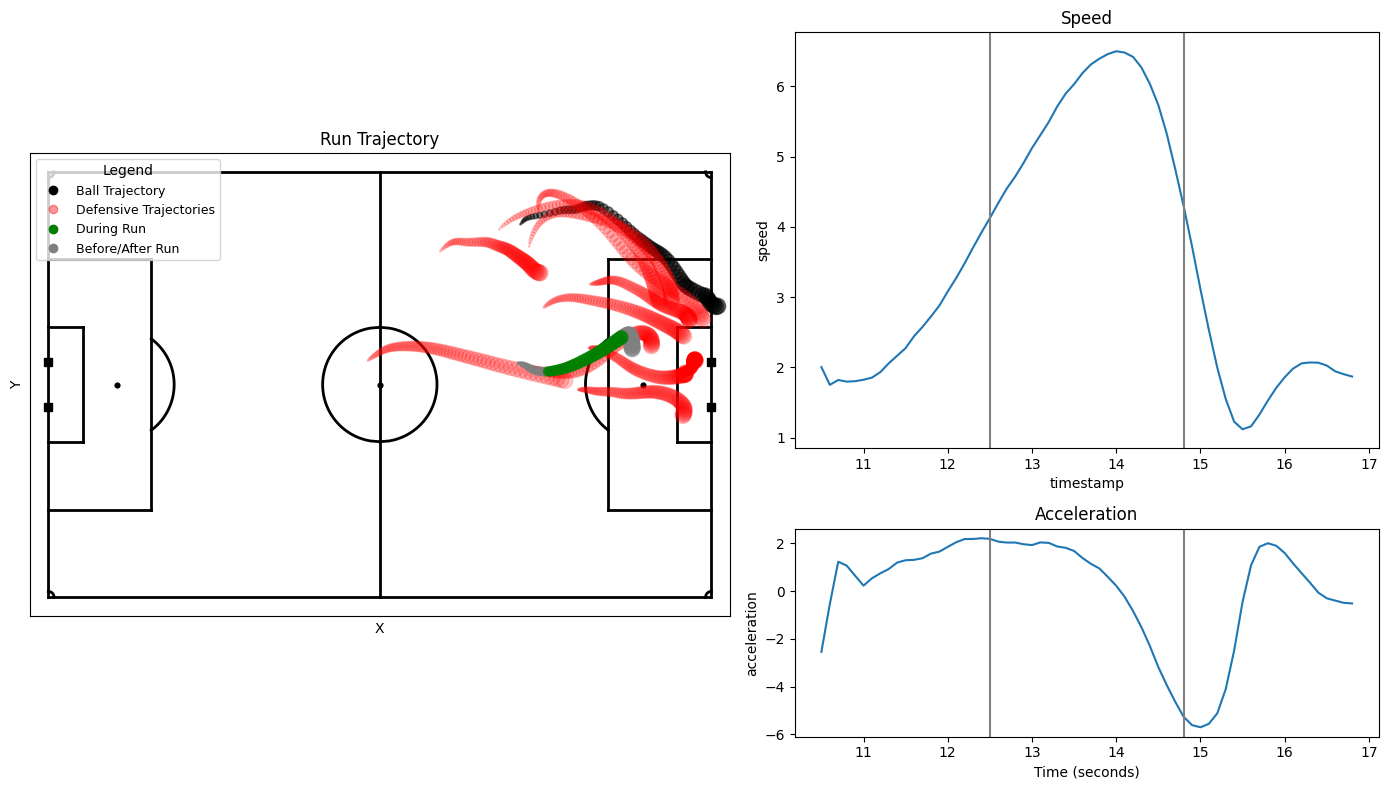

In [131]:
fig = plt.figure(figsize=(14, 8))

# ---- layout ----
gs = fig.add_gridspec(
    nrows=2, ncols=2,
    width_ratios=[1.2*2, 2],
    height_ratios=[1*2, 1]
)

# ---- left: run trajectory (spans all rows) ----
ax_run = fig.add_subplot(gs[:, 0])

plot_run(run=run,tracking_data=tracking_data,player_to_team=player_to_team,ax=ax_run)

ax_run.set_title("Run Trajectory")
ax_run.set_xlabel("X")
ax_run.set_ylabel("Y")
ax_run.set_aspect("equal")

# ---- right: kinematics ----
ax_spd = fig.add_subplot(gs[0, 1])
ax_acc = fig.add_subplot(gs[1, 1], sharex=ax_spd)

start = run_tracking[run_tracking.run_active]["timestamp"].iloc[0]
end = run_tracking[run_tracking.run_active]["timestamp"].iloc[-1]

sns.lineplot(data=run_tracking, x="timestamp", y="speed", ax=ax_spd)
ax_spd.set_title("Speed")
ax_spd.axvline(start,color = "grey")
ax_spd.axvline(end,color="grey")

sns.lineplot(data=run_tracking, x="timestamp", y="acceleration", ax=ax_acc)
ax_acc.set_title("Acceleration")
ax_acc.set_xlabel("Time (seconds)")
ax_acc.axvline(start,color = "grey")
ax_acc.axvline(end,color="grey")

plt.tight_layout()
plt.show()

In [135]:
def find_highest_speed_frame(run_tracking):
    frame = run_tracking.set_index("frame_id")["speed"].idxmax()
    return frame

def find_highest_accel_frame(run_tracking):
    frame = run_tracking.set_index("frame_id")["acceleration"].idxmax()
    return frame
find_highest_accel_frame(run_tracking)
    


np.int64(2634)

In [136]:
run_tracking["frame_id"]

3543    2615
3631    2616
3675    2617
3741    2618
3807    2619
        ... 
7437    2674
7503    2675
7569    2676
7635    2677
7701    2678
Name: frame_id, Length: 64, dtype: int64